# Nontrivial Landscapes

This notebook demonstrates the functionality of hyvis using some more interesting examples of landscapes, in particular using a quantum circuit.

In order to run this, you need additional dependencies. Install them with:

```bash
pip install hyvis[qaoa]
```

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from hyvis.basic_scans import AffineSubspace, landscape_scan_linear
import josstyle


### Maxcut with QAOA

A quantum solution to the combinatorial problem of coloring a graph such that the sum of weights for edges with two different colors is maximal.

This implementation is due to Michele Minervini and Chia-Tso Lai.

What's important is that you wrap the function in such a way that it only takes an np.ndarray as input. It might also be wise to fix inputs that you don't want to change during the visualization anyways, such as the weight matrix in this case.

In [2]:
from hyvis.native_landscapes import (
    maxcut_landscape_qaoa,
    qaoa_circuit_with_layers,
)
import networkx as nx

Here we want to optimize the following graph:

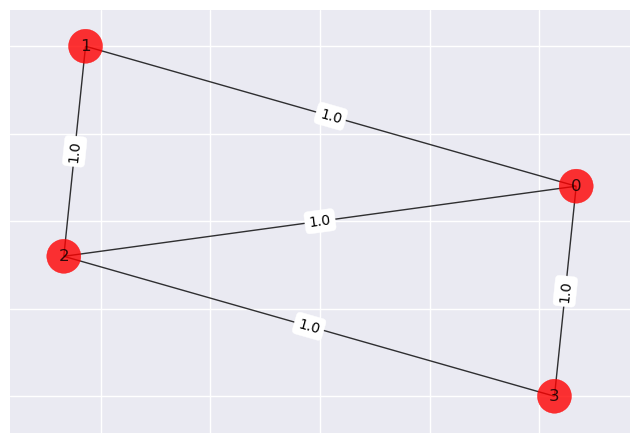

In [3]:
# Generating a graph

n = 4  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 3, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
]  # tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G,
        node_color=colors,
        node_size=600,
        alpha=0.8,
        ax=default_axes,
        pos=pos,
    )
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

We have previously implemented qaoa in a quantum circuit. That function takes as input the weight matrix and an even number of angles. We do not want to vary the weight matrix during visualization therefore we redefine the function so that w is not part of the argument anymore. We can just set it independently.

In [4]:
# defining the weight matrix using the above graph
n = 4
w = np.zeros([n, n])

for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]


def maxcut_cost_hyvis(params):
    parameters = params.flatten()
    return maxcut_landscape_qaoa(parameters, w)


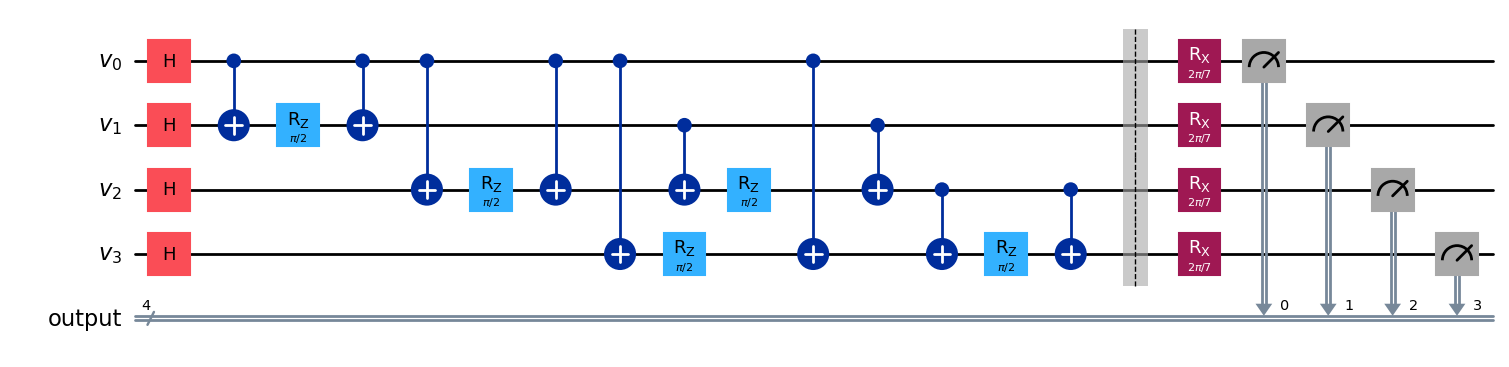

In [5]:
qc = qaoa_circuit_with_layers(
    w=w, gamma_list=[np.pi / 2], beta_list=[np.pi / 7]
)
qc.draw(output="mpl")

We can now easily visualize the landscape by choosing and scanning the subspace we want. Here for two angles.

Also since simulating the circuit is take a bit longer we use here the parallelization feature of hyvis to speed up the scanning process.

In [6]:
# Subspace to scan
subspace = AffineSubspace(
    directions=np.array([[1, 0], np.array([0, 1])]),
    center=np.pi * np.zeros([1, 2]),
)

# Scan the landscape
scan = landscape_scan_linear(
    func=maxcut_cost_hyvis,
    subspace=subspace,
    scope=np.pi,
    resolution=1,
)

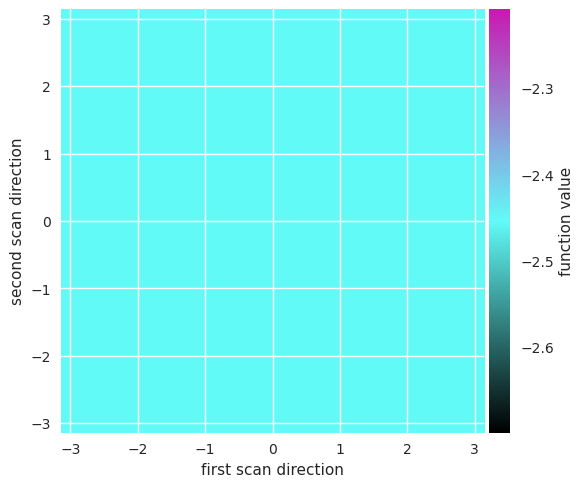

In [7]:
scan.show()

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(cax=cax, label="function value")

In [8]:
# from hyvis.basic_scans import hessian_scan

# scan_H, H = hessian_scan(func=maxcut_cost_hyvis,subspace=subspace,resolution=50)
# scan_H.show()
# plt.legend()

### Multivariate Gaussian

Here we train a multivariate Gaussian with simple gradient descent along the landscape arising from KL-divergence to the standard normal distribution.
We can then use the stepwise_hessian function to generate a video that shows you all 1D scans in the directions of the Hessian eigenvalues (not orthormalized) of the landscape restricted to the normal space of the trajectory at each step. This can tell you something about the of the space that the training had to navigate through.

First we generate the training trajectory. Here we look at 2D normal distributions.
Our multivarite KL loss function takes as input the flattened array [mean_1, covariance_1, mean_2, covariance_2].
The center of the Affine subspace (gasp) that we define here is the start of our training, so by the above scheme the first two entries are the mean of our distribution (10,32) and the the third to sixth entry are the flattened covariance matrix ((8,1),(1,4)). The rest of the entries are the parameters of the standard normal distribution.
Note that the directions of the Affine Subspace only cover the first half of the parameters, that means only the first distribution can change and it will try to get closer to the standard normal distribution which is fixed.

In [9]:
from hyvis.native_landscapes import (
    relative_entropy_multivariate_gaussians_unified as testfunc,
    gradient_descent_training,
)
from hyvis.video_scans import trajectory_scan_stepwise_hessian

In [10]:
gasp = AffineSubspace(
    directions=np.array(
        [
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        ]
    ),
    center=np.array([[10, 32, 8, 1, 1, 4, 0, 0, 1, 0, 0, 1]]),
)
trajectory = gradient_descent_training(
    func=testfunc, subspace=gasp, rate=1, steps=100, epsilon=0.0001
)
resolution = 50

The rest works the same as the stepwise PCA scan.

In [11]:
scan1 = trajectory_scan_stepwise_hessian(
    func=testfunc, trajectory=trajectory, resolution=resolution
)

What you can see in the video are 1D scans in the direction of each Hessian eigenvector at that point in the training.
Eigenvalues are sorted highest to lowest. Since we are restricting to the normal space of the trajectory there are 11 scan directions.

In [12]:
scan1.animate()